# Static power flow

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from cvxpower import *

matplotlib.rc("figure", figsize=(7,7))
matplotlib.rc("lines", linewidth=2)

## Basic examples

### Hello world

In [2]:
load = FixedLoad(power=100)
gen = Generator(power_max=1000, alpha=0.01, beta=100)
net = Net([load.terminals[0], gen.terminals[0]])
network = Group([load, gen], [net])

network.init_problem()
network.problem.solve()
print(network.results.summary())

Status: optimal
Terminal                  Power
--------                  -----
FixedLoad[0]             100.00
Generator[0]            -100.00

Net                       Price
---                       -----
Net                    102.0000

Device                  Payment
------                  -------
FixedLoad              10200.00
Generator             -10200.00

Power and price are averages over the time horizon. Payment is total.



### Curtailable load

In [3]:
load = CurtailableLoad(power=1000, alpha=150)
gen = Generator(power_max=1000, alpha=1, beta=100)
net = Net([load.terminals[0], gen.terminals[0]])
network = Group([load, gen], [net])

network.init_problem()
network.problem.solve()
print(network.results.summary())

Status: optimal
Terminal                  Power
--------                  -----
CurtailableLoad[0]        25.00
Generator[0]             -25.00

Net                       Price
---                       -----
Net                    150.0000

Device                  Payment
------                  -------
CurtailableLoad         3750.00
Generator              -3750.00

Power and price are averages over the time horizon. Payment is total.



### Two generators, transmission line

In [4]:
load = FixedLoad(power=100)
gen1 = Generator(power_max=1000, alpha=0.01, beta=100, name="Gen1")
gen2 = Generator(power_max=100, alpha=0.1, beta=0.1, name="Gen2")
line = TransmissionLine(power_max=50)

net1 = Net([load.terminals[0], gen1.terminals[0], line.terminals[0]])
net2 = Net([gen2.terminals[0], line.terminals[1]])
network = Group([load, gen1, gen2, line], [net1, net2])

network.init_problem()
network.problem.solve()
print(network.results.summary())

Status: optimal
Terminal                  Power
--------                  -----
FixedLoad[0]             100.00
Gen1[0]                  -50.00
Gen2[0]                  -50.00
TransmissionLine[0]      -50.00
TransmissionLine[1]       50.00

Net                       Price
---                       -----
Net                    101.0000
Net                     10.1000

Device                  Payment
------                  -------
FixedLoad              10100.00
Gen1                   -5050.00
Gen2                    -505.00
TransmissionLine       -4545.00

Power and price are averages over the time horizon. Payment is total.



### Three buses

Figure 2.1 from Kraning, et al. without the battery.

![Three bus example](./three_bus.png)



In [5]:
load1 = FixedLoad(power=50, name="Load1")
load2 = FixedLoad(power=100, name="Load2")
gen1 = Generator(power_max=1000, alpha=0.01, beta=100, name="Gen1")
gen2 = Generator(power_max=100, alpha=0.1, beta=0.1, name="Gen2")
line1 = TransmissionLine(power_max=50)
line2 = TransmissionLine(power_max=10)
line3 = TransmissionLine(power_max=50)

net1 = Net([load1.terminals[0], gen1.terminals[0], line1.terminals[0], line2.terminals[0]])
net2 = Net([load2.terminals[0], line1.terminals[1], line3.terminals[0]])
net3 = Net([gen2.terminals[0], line2.terminals[1], line3.terminals[1]])
network = Group([load1, load2, gen1, gen2, line1, line2, line3], [net1, net2, net3])

network.init_problem()
network.problem.solve()
print(network.results.summary())

Status: optimal
Terminal                  Power
--------                  -----
Load1[0]                  50.00
Load2[0]                 100.00
Gen1[0]                  -90.00
Gen2[0]                  -60.00
TransmissionLine[0]       50.00
TransmissionLine[1]      -50.00
TransmissionLine[0]      -10.00
TransmissionLine[1]       10.00
TransmissionLine[0]      -50.00
TransmissionLine[1]       50.00

Net                       Price
---                       -----
Net                    101.8001
Net                    926.6617
Net                     12.1000

Device                  Payment
------                  -------
Load1                   5090.00
Load2                  92666.17
Gen1                   -9161.98
Gen2                    -726.00
TransmissionLine      -41243.11
TransmissionLine        -897.03
TransmissionLine      -45728.06

Power and price are averages over the time horizon. Payment is total.



## Grouping devices

We can wrap up several devices and nets into a single device

In [6]:
solar = Generator(power_max=10, alpha=0, beta=0, name="Solar")
load = FixedLoad(power=13)
line = TransmissionLine(power_max=25)
net = Net([load.terminals[0], solar.terminals[0], line.terminals[0]])
home = Group([solar, load, line], [net], [line.terminals[1]], name="Home")

grid = Generator(power_max=1e6, alpha=0.05, beta=100, name="Grid")
meter = Net([line.terminals[1], grid.terminals[0]], name="Meter")
network = Group([home, grid], [meter])

network.init_problem()
network.problem.solve()
print(network.results.summary())

Status: optimal
Terminal                  Power
--------                  -----
Solar[0]                 -10.00
FixedLoad[0]              13.00
TransmissionLine[0]       -3.00
TransmissionLine[1]        3.00
Grid[0]                   -3.00

Net                       Price
---                       -----
Net                    100.2993
Meter                  100.2998

Device                  Payment
------                  -------
Solar                  -1003.00
FixedLoad               1303.89
TransmissionLine           0.00
Grid                    -300.90

Power and price are averages over the time horizon. Payment is total.



## Varying parameters

We can modify a single parameter and reoptimize, which is useful for sweeping over a parameter range.

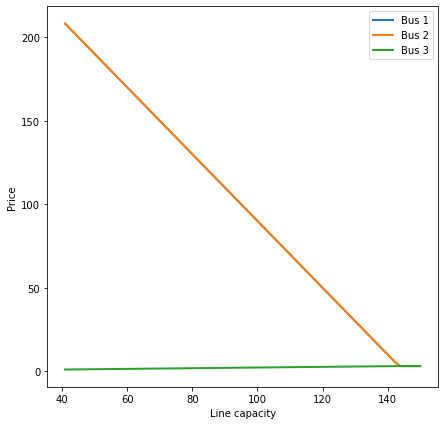

In [7]:
load1 = FixedLoad(power=50, name="Load1")
load2 = FixedLoad(power=100, name="Load2")
gen1 = Generator(power_max=100, alpha=1, beta=10, name="Gen1")
gen2 = Generator(power_max=1000, alpha=0.01, beta=0, name="Gen2")
line1 = TransmissionLine(power_max=100)
line2 = TransmissionLine(power_max=10)
line3 = TransmissionLine(power_max=Parameter(1))

net1 = Net([load1.terminals[0], gen1.terminals[0], line1.terminals[0], line2.terminals[0]])
net2 = Net([load2.terminals[0], line1.terminals[1], line3.terminals[0]])
net3 = Net([gen2.terminals[0], line2.terminals[1], line3.terminals[1]])
network = Group([load1, load2, gen1, gen2, line1, line2, line3], [net1, net2, net3])

network.init_problem()
xs = np.linspace(0, 150, 100)
prices = np.empty((len(xs), 3))
for i, x in enumerate(xs):
    line3.power_max.value = [x]
    network.problem.solve()
    prices[i,:] = [net.price for net in network.nets]
    
plt.plot(xs, prices)
plt.xlabel("Line capacity")
plt.ylabel("Price")
plt.legend(["Bus 1", "Bus 2", "Bus 3"])